# Data Clearning and Reconstruction

In [ ]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# data preprocessing
import os

'''
We are training the model based on the overhead images inside of side-angle videos which are more complex and low quality.
Since the original dataset provides the split of the training/testing set based on the images (side-angle videos and overhead), we need to find all dish ids that are present in the overhead images.
Therefore, we first find the ids in the training/testing set and then find the intersection of these ids with the overhead images.

'''

nutrition5k_path = '../../data/nutrition5k'
nutrition5k_overhead_path = os.path.join(nutrition5k_path, 'realsense_overhead')
train_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_train_ids.txt')
test_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_test_ids.txt')
original_labels = os.path.join(nutrition5k_path, 'metadata/dish_metadata_cafe1.csv')
ingredients_metadata = os.path.join(nutrition5k_path, 'metadata/ingredients_metadata.csv')

"""
realsense_overhead
    - image_index
        - depth_color.png
        - depth_raw.png
        - rgb.png
        
        
side_angles
    - image_index
        - frames_sampled30
            - camera_{}_frame_{}.png
            
metadata
    - dish_metadata_cafe1.csv
        - dish_id, dish_name, calories, mass, fat, carb, protein, ingredients content
    - dish_metadata_cafe2.csv
    - ingredients_metadata.csv
"""

overhead_ids = set()
for file in os.listdir(nutrition5k_overhead_path):
    overhead_ids.add(file)
    
print('Number of unique overhead ids: ', len(overhead_ids))

train_dis = set()
test_dis = set()
with open(train_dir, 'r') as f:
    train_list = f.readlines()
    for i in train_list:
        train_dis.add(i.strip())
        
with open(test_dir, 'r') as f:
    test_list = f.readlines()
    for i in test_list:
        test_dis.add(i.strip())

print('Valid Training Samples:', len(train_dis.intersection(overhead_ids)))
print('Intersection (Test and Overhead):', len(test_dis.intersection(overhead_ids)))

valid_overhead_ids = train_dis.intersection(overhead_ids).union(test_dis.intersection(overhead_ids))
print('Number of valid overhead ids:', len(valid_overhead_ids))

labels_dict = {}
with open(original_labels, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip().split(',')
        if line[0] in valid_overhead_ids:
            labels_dict[line[0]] = line[1:]

print('Number of valid overhead ids with labels:', len(labels_dict))
## Example of labels_dict
print('Example of labels_dict:', labels_dict['dish_1562699612'])

Number of unique overhead ids:  3490
Valid Training Samples: 2755
Intersection (Test and Overhead): 507
Number of valid overhead ids: 3262
Number of valid overhead ids with labels: 3262
Example of labels_dict: ['98.391266', '74.000000', '2.671786', '15.661942', '2.793359', 'ingr_0000000023', 'brown rice', '22.000000', '24.42', '0.198', '5.06', '0.572', 'ingr_0000000377', 'quinoa', '50.485435', '60.582522', '0.959223265', '10.60194135', '2.22135914', 'ingr_0000000161', 'olive oil', '1.514563', '13.38873692', '1.514563', '0.0', '0.0']


In [16]:
# Reconstruction of the dataset (Including Images and Labels)
import time

start_time = time.time()
print('Start Reconstruction...')

# create a new dataset containing only the valid overhead ids
data_path = '../../data/nutrition5k_reconstructed'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
image_path = os.path.join(data_path, 'images')
if not os.path.exists(image_path):
    os.makedirs(image_path)

# index = 0
# for i in valid_overhead_ids:
#     curr_overhead_image_path = os.path.join(nutrition5k_overhead_path, i)
        
#     for overhead_pics in os.listdir(curr_overhead_image_path):
#         if overhead_pics != 'rgb.png':
#             continue
#         # print overhead pics's absolute path
#         abs_address = os.path.join(curr_overhead_image_path, overhead_pics)
#         os.system('cp ' + abs_address + ' ' + os.path.join(image_path, f'{i}.jpeg'))
#         index += 1
        
# print('Number of images:', index)
        
# reconstruct the labels and metadata
metadata_path = os.path.join(data_path, 'metadata')
if not os.path.exists(metadata_path):
    os.makedirs(metadata_path)
    
# Reconstruct the training and testing metadata
# train_ids_path = os.path.join(metadata_path, 'train_ids.csv')
# test_ids_path = os.path.join(metadata_path, 'test_ids.csv')

# index = 0
# with open(train_ids_path, 'w') as f:
#     for i in train_dis.intersection(valid_overhead_ids):
#         f.write(i + '\n')
#         index += 1
# print('Number of training ids:', index)

# index = 0
# with open(test_ids_path, 'w') as f:
#     for i in test_dis.intersection(valid_overhead_ids):
#         f.write(i + '\n')
#         index += 1
        
# print('Number of testing ids:', index)

# Reconstruct the labels
ingr_list = []
for ids in valid_overhead_ids:
    data = labels_dict[ids]
    for indx, i in enumerate(data[5:]):
        if i.startswith('ingr_0000000'):
            # take non-zero part of the string from -1 position
            ingr = data[5 + indx + 1]
            if ingr == '':
                print('Empty ingredient:', ids)
            ingr_list.append(ingr) if ingr not in ingr_list else ingr_list
            
print('Number of unique ingredients:', len(ingr_list)) 
                    
labels_path = os.path.join(data_path, 'labels')
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
index = 0
labels_file = os.path.join(labels_path, 'labels.csv')
with open(labels_file, 'w') as f:
    caption_str = 'id,calories,mass,fat,carb,protein,'
    for ingr in ingr_list:
        caption_str += ingr + ','
        
    f.write(caption_str[:-1] + '\n')
    
    for ids in valid_overhead_ids:
        data = labels_dict[ids]
        # take only the first 5 columns (calories, mass, fat, carb, protein)
        nutritional_facts = data[:5]
        ingredients = []
        for indx, i in enumerate(data[5:]):
            if i.startswith('ingr_0000000'):
                # take non-zero part of the string from -1 position
                ingr = data[5 + indx + 1]
                ingr_mass = data[5 + indx + 2]
                ingredients.append((ingr, ingr_mass))
        
        ingr_index = []
        for ingr in ingr_list:
            for i in ingredients:
                if ingr == i[0]:
                    ingr_index.append(i[1])
                    break
                
            else:
                ingr_index.append(str(float(0)))
                
        f.write(ids + ',' + ','.join(nutritional_facts) + ',' + ','.join(ingr_index) + '\n')
        index += 1
            
print('Number of labels:', index)

end_time = time.time()
print('Data preprocessing done!')
print('Time taken to copy images: ', end_time - start_time)
print('Data stored in: ', data_path)


Start Reconstruction...
Number of unique ingredients: 199
Number of labels: 3262
Data preprocessing done!
Time taken to copy images:  0.9412937164306641
Data stored in:  ../../data/nutrition5k_reconstructed


In [17]:
# Sanity Check
df = pd.read_csv(labels_file, sep=',')

print('Number of ids in both the training and testing set:', len(train_dis.intersection(test_dis)))

print()

df

Number of ids in both the training and testing set: 0



,id,calories,mass,fat,carb,protein,brown rice,quinoa,olive oil,carrot,...,pepperoni,orange with peel,mozzarella cheese,baby carrots,banana with peel,wheat bread,chilaquiles,pasta salad,balsamic vinegar,toast
0,dish_1562699612,98.391266,74.0,2.671786,15.661942,2.793359,22.000000,50.485435,1.514563,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dish_1558722322,37.720001,92.0,0.184000,9.200000,0.828000,0.000000,0.000000,0.000000,92.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dish_1567007848,100.300003,243.0,0.580000,24.836000,1.655000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dish_1563898084,419.493378,384.0,22.837477,30.001255,24.971926,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dish_1561406762,17.205421,35.0,0.414091,3.452406,0.310967,0.000000,0.000000,0.345040,34.504005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,dish_1560801797,25.655659,96.0,0.700594,4.108631,1.344873,0.000000,0.000000,0.414303,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3258,dish_1563389153,346.454468,224.0,5.393479,69.070702,11.697627,0.000000,0.000000,3.398001,61.121380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3259,dish_1558725253,33.950001,97.0,0.388000,6.790000,2.328000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3260,dish_1561749348,165.446945,93.0,8.394006,3.661341,17.270729,13.966586,0.000000,2.653651,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Visualization

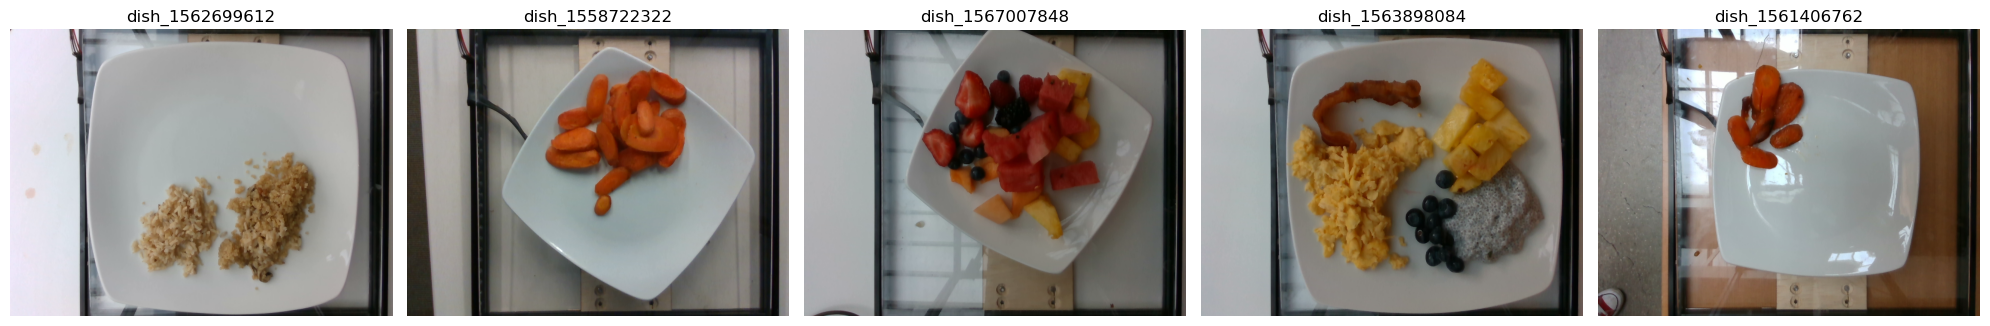

                id    calories   mass        fat       carb    protein  \
0  dish_1562699612   98.391266   74.0   2.671786  15.661942   2.793359   
1  dish_1558722322   37.720001   92.0   0.184000   9.200000   0.828000   
2  dish_1567007848  100.300003  243.0   0.580000  24.836000   1.655000   
3  dish_1563898084  419.493378  384.0  22.837477  30.001255  24.971926   
4  dish_1561406762   17.205421   35.0   0.414091   3.452406   0.310967   

   brown rice     quinoa  olive oil     carrot  ...  pepperoni  \
0        22.0  50.485435   1.514563   0.000000  ...        0.0   
1         0.0   0.000000   0.000000  92.000000  ...        0.0   
2         0.0   0.000000   0.000000   0.000000  ...        0.0   
3         0.0   0.000000   0.000000   0.000000  ...        0.0   
4         0.0   0.000000   0.345040  34.504005  ...        0.0   

   orange with peel  mozzarella cheese  baby carrots  banana with peel  \
0               0.0                0.0           0.0               0.0   
1         

In [18]:
import matplotlib.pyplot as plt
from PIL import Image


# this function will plot images in the form of a grid with 1 row and 5 columns where images are placed in the first batch
def plotImages(images_arr, ids):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    # show ids as well
    for img, ax, id in zip(images_arr, axes, ids):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(id)
    plt.tight_layout()
    plt.show()

# Displaying the first 5 images from the dataset
images = [Image.open(os.path.join(image_path, f'{i}.jpeg')) for i in df['id'][:5]]
ids = df['id'][:5]
plotImages(images, ids)

# Displaying the first 5 labels from the dataset
print(df.head())